In [2]:
%%html
<style>
    .gray {
        background-color: #dfe0e8;
    }
</style>

## The Reuters Corpus

<div class="gray">
Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story,
anchored in some analytical tools we have learned in this class, using this data. For example:
    
- you could cluster authors or documents and tell a story about what you find.
- you could look for common factors using PCA.
- you could train a predictive model and assess its accuracy, constructing features for each document that
maximize performance.
- you could do anything else that strikes you as interesting with this data.
Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the
data, and so forth. Make sure you include at least one really interesting plot (although more than one might be
necessary, depending on your question and approach.)

Format your write-up in the following sections, some of which might be quite short:

- Question: What question(s) are you trying to answer?
- Approach: What approach/statistical tool did you use to answer the questions?
 - Results: What evidence/results did your approach provide to answer the questions? (E.g.
any numbers, tables, figures as appropriate.)
- Conclusion: What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.

Regarding the data itself: In the C50train directory, you have 50 articles from each of 50 different authors (one
author per directory). Then in the C50test directory, you have another 50 articles from each of those same 50
authors (again, one author per directory). This train/test split is obviously intended for building predictive models,
but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want.
Just make it compelling!

Note: if you try to build a predictive model, you will need to figure out a way to deal with words in the test set that
you never saw in the training set. This is a nontrivial aspect of the modeling exercise. (E.g. you might simply
ignore those new words.)

This question will be graded according to three criteria:

1. the overall “interesting-ness” of your question and analysis.
2. the clarity of your description. We will be asking ourselves: could your analysis be reproduced by a competent
data scientist based on what you’ve said? (That’s good.) Or would that person have to wade into the code in
order to understand what, precisely, you’ve done? (That’s bad.)
3. technical correctness (i.e. did you make any mistakes in execution or interpretation?)
</div>

### Question:
Some authors from Reuters likely have more similar writing styles than others, and they may appeal to similar audiences. If Reuters wants to increase their viewership by recommending similar authors to readers based on their favorite authors, which authors have similar writing styles and would be recommended together?

### Method:
In order to determine which authors would be recommended together, I clustered authors based on their language usage. Using author's language usage allows me to pick up on similar topics discussed among authors as well as prose. Authors that were in the same cluster as a reader's favorite author would be recommended to the reader. My method is detailed more below: 
1. Read in the training and test data along with author names from the Reuters C50 Corpus.
2. Combine the training and test data into one dataframe. Each row contains an article and it's corresponding author.
3. Get each author's total body of work by grouping the dataframe by author and joining all of the author's articles into one body of text.
4. Process each author's text by tokenizing the text into lowercase words. Remove punctuation and stop words from tokens too. Then, stem the tokens.
5. Create a TF-IDF matrix where each rows corresponds to an author's body of work and each column corresponds to a word that was present in the whole corpus.
6. Reduce the sparse TF-IDF matrix into a dense matrix using PCA. Since there are only 50 authors in the dataset, there must be fewer than 50 PCs. To reduce the dimensionality while maintaining as much information as possible, choose the minimum number of PCAs that account for at least 50% of the variance in the TF-IDF matrix.
7. Determine the most important terms for each PC by getting the 10 features with the largest absolute loading. Intepret what each of the principal components represents based on the 10 largest loadings to make cluster results more interpretable later.
8. Determine the best number of clusters to use by examining what value of k maximizes the silhouette score. This will maximize the clarity of clusters by minimizing the distance within clusters and maximizing the difference between clusters.
9. Cluster the authors using the optimal number of clusters.
10. Visualize the clusters of authors and report which authors should be recommended together.
11. Interpret the clusters by determining the cluster centers. The cluster centers are based on the PCs used for clustering, so you will have to go back to your interpretation of the PCs you kept for analysis.

### Results

In [3]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer

nltk.download('punkt') # for tokenizing

# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("../data/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("../data/ReutersC50/C50test")
corpus = train_texts + test_texts
authors = train_labels + test_labels

# get each author's whole body of work
df = pd.DataFrame({'articles':corpus, 'author':authors})
author_texts = df.groupby('author')['articles'].apply(lambda x: ' '.join(x)).reset_index()

[nltk_data] Downloading package punkt to /Users/kenne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [105]:
# Helper function to tokenize, remove punctuation, and stem
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

[nltk_data] Downloading package stopwords to /Users/kenne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
# get TF-IDF matrix
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=preprocess_text, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(author_texts['articles'])

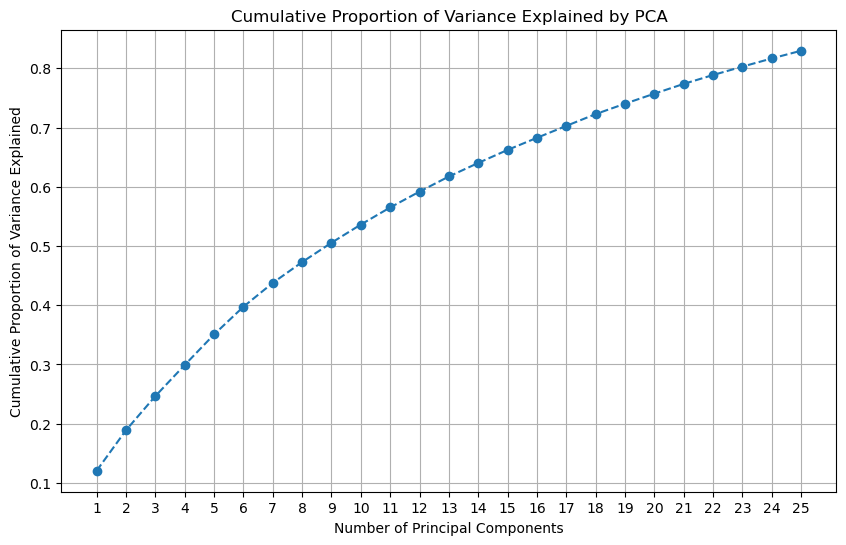

In [152]:
# PCA for clustering
pca = PCA(n_components=25)
reduced_data_pca = pca.fit_transform(tfidf_matrix.toarray())  # Convert sparse matrix to dense matrix

# determine best number of PCs
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('Cumulative Proportion of Variance Explained by PCA')
plt.grid(True)
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.show()
pca_df = pd.DataFrame(reduced_data_pca).loc[:,0:9]

Moving forward, I will use 9 principal components for clustering to maintain as much information as possible while reducing the issues with using high-dimensional data for clustering.

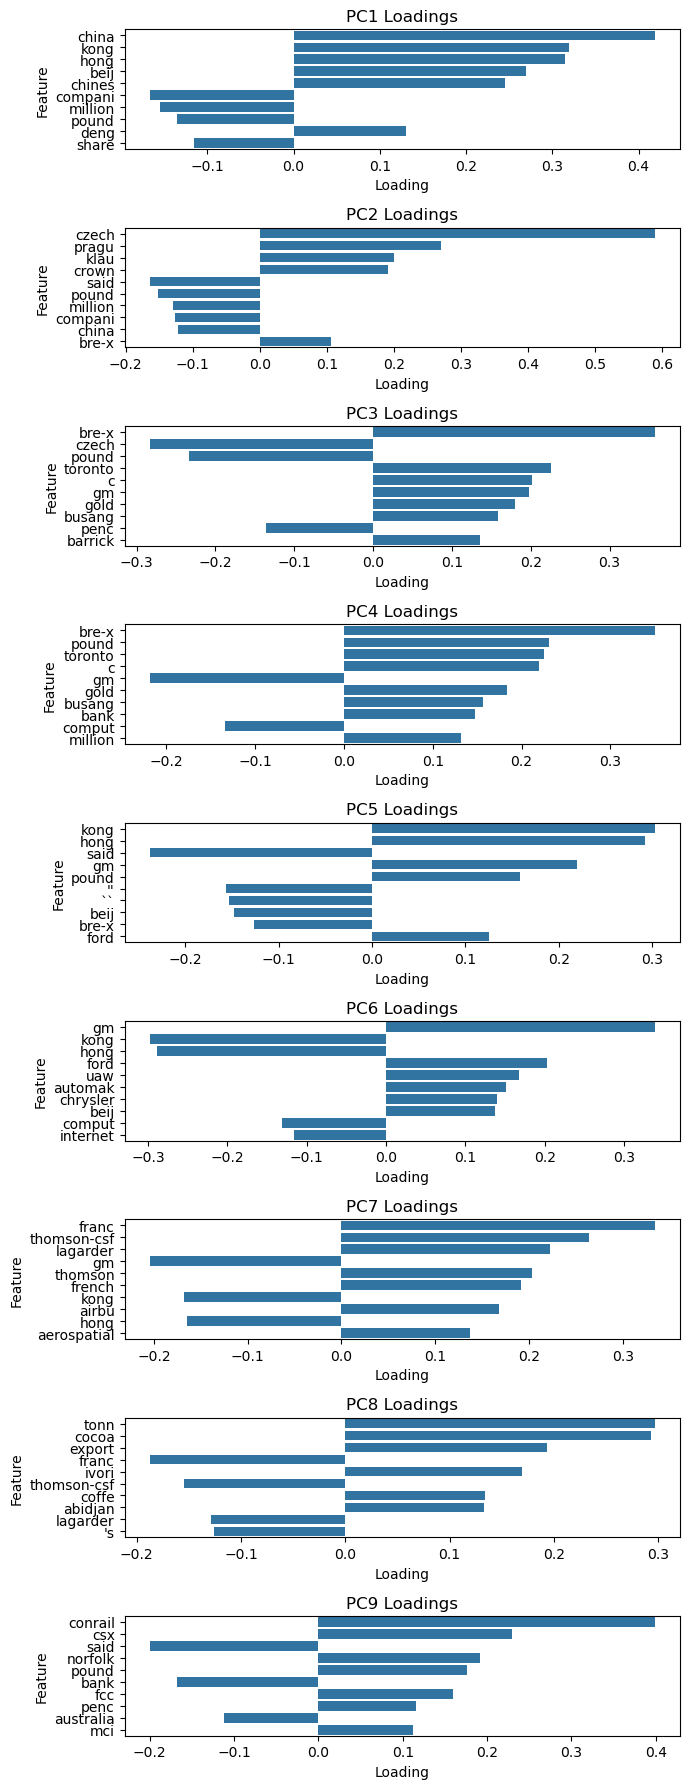

In [269]:
feature_names = vectorizer.get_feature_names_out()  # Get feature names

# Assuming `pca` is the PCA object and `components_` are the principal component loadings
# For demonstration purposes, I'll use a sample PCA components matrix
pca_components = pca.components_  # Shape: (n_components, n_features)

# Convert PCA components to a DataFrame for easier manipulation
components_df = pd.DataFrame(pca_components, columns=feature_names)
components_df = components_df.iloc[:9]

fig, axes = plt.subplots(nrows = 9, ncols = 1, figsize = (7, 18))
axes = axes.flatten()
for i, component in components_df.iterrows():
    abs_component = component.abs()
    top_indices = abs_component.nlargest(10).index
    top_features_df = pd.DataFrame({
        'Feature': top_indices,
        'Loading': component[top_indices].values,
        'Principal Component': f'PC{i+1}'
    })
    sns.barplot(y = top_features_df['Feature'], x = top_features_df['Loading'], ax = axes[i])
    axes[i].set_title(f'PC{i+1} Loadings')
plt.tight_layout()
plt.show()

The top 10 loadings (10 largest absolute values) are displayed for each PC above. There are many more terms that make up each PC, but to get a general sense, I just looked at the loadings that contributed the most to projections onto that PC. Based on the most important features for each PC above, here are the interpretations of each principal component:
- PC1: News about China
- PC2: News about Czech
- PC3: News related to Bre-X, a Candian company involved in a gold mining scandal
- PC4: Also news related to Bre-X and gold
- PC5: News about GM and Ford in China
- PC6: News related to automobile manufacturers, GM and Ford, not as focused on China
- PC7: French market news
- PC8: New related to export of cocoa, ivory, and coffee
- PC9: News about Conrail, a railway service in the northeastern United States

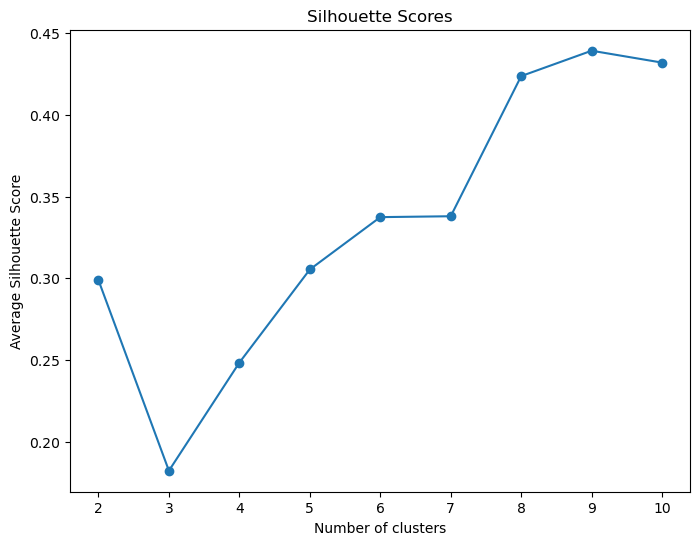

In [160]:
# cluster on PCs
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

The optimal number of clusters is 9 because it maximes within cluster similarity and between cluster differences. The clusters ahve relatively good separation, though it could be better. This indicates that authors within a cluster are relatively similar, but there is not a stark difference between authors in different clusters. This might be because all of the authors are writing for Reuters, which primarily provides business market and financial information. Therefore, all of the authors already have something in common.

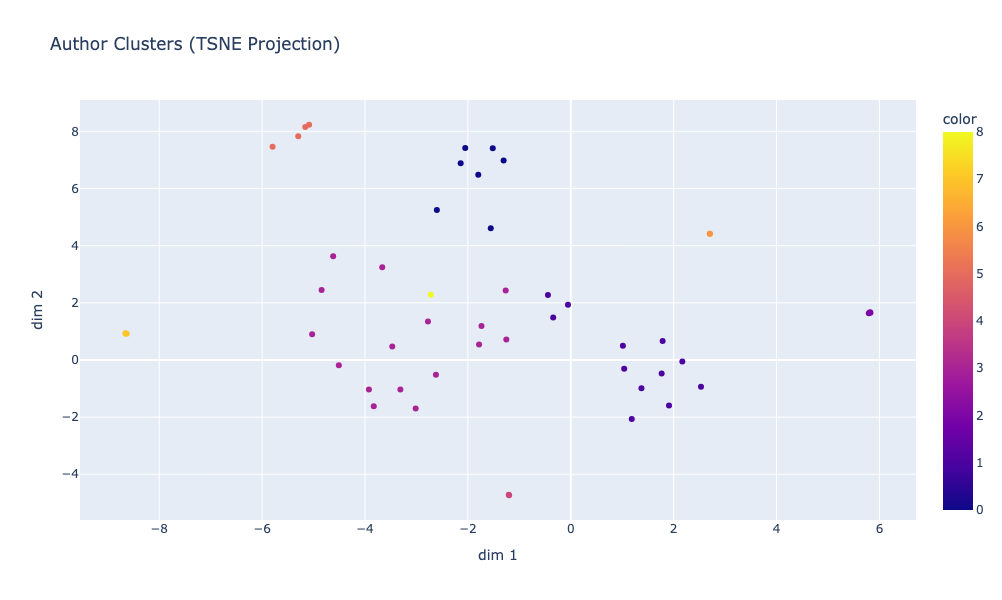

In [169]:
kmeans = KMeans(n_clusters = 9, init = 'k-means++', n_init = 10, random_state = 0)
kmeans.fit(pca_df)
labels = kmeans.labels_

tsne = TSNE(n_components=2, perplexity=15)
tsne_results = tsne.fit_transform(pca_df)

# interactive scatterplot
import plotly.express as px
color_map = {label: f'rgba({i*50%255}, {i*100%255}, {i*150%255}, 0.8)' for i,label in enumerate(pd.Series(labels).unique())}
fig = px.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], 
                 color = labels, color_discrete_map=color_map, 
                 hover_name=author_texts['author'], 
                 title="Author Clusters (TSNE Projection)")
fig.update_layout(
    xaxis_title="dim 1",
    yaxis_title="dim 2",
    height=600,
    width=600,
)
# Show the plot
fig.show()

The plot above displays how the authors were clustered together. The x and y-axis are the principal components project into 2D using TSNE. Each cluster is displayed using a different color. If you hover over the points, you can see which author corresponds to each point.

In [179]:
author_texts['labels'] = labels
for  i in author_texts['labels'].unique():
    print(f'These are the authors in cluster {i}:')
    print(author_texts.loc[author_texts['labels'] == i, 'author'])
    print('\n')

These are the authors in cluster 3:
0         AaronPressman
5           BradDorfman
9           EricAuchard
10       FumikoFujisaki
20          KarlPenhaul
22       KevinDrawbaugh
25    KouroshKarimkhany
28      LynnleyBrowning
31           MartinWolk
32         MatthewBunce
33        MichaelConnor
35            NickLouth
36      PatriciaCommins
40         RogerFillion
41          SamuelPerry
46       TheresePoletti
Name: author, dtype: object


These are the authors in cluster 7:
1       AlanCrosby
13      JanLopatka
18    JohnMastrini
Name: author, dtype: object


These are the authors in cluster 1:
2     AlexanderSmith
4      BernardHickey
8      EdnaFernandes
16    JoWinterbottom
17          JoeOrtiz
19      JonathanBirt
21         KeithWeir
23     KevinMorrison
24     KirstinRidley
30      MarkBendeich
44       SimonCowell
47        TimFarrand
Name: author, dtype: object


These are the authors in cluster 0:
3     BenjaminKangLim
11     GrahamEarnshaw
14      JaneMacartney
27     

Above is a list of all the authors that were clustered together. Authors within a cluster can be assumed to be more similar to each other than those outside of the cluster. Some authors, like Robin Sidel aren't similar to any other authors. Reuters could use this list to recommend new authors to readers based on a reader's favorite author. For example, if a reader really liked Aaron Pressman, they may also like Brad Dorfman because these authors had similar language usage, perhaps indicating similar topic coverage or prose.

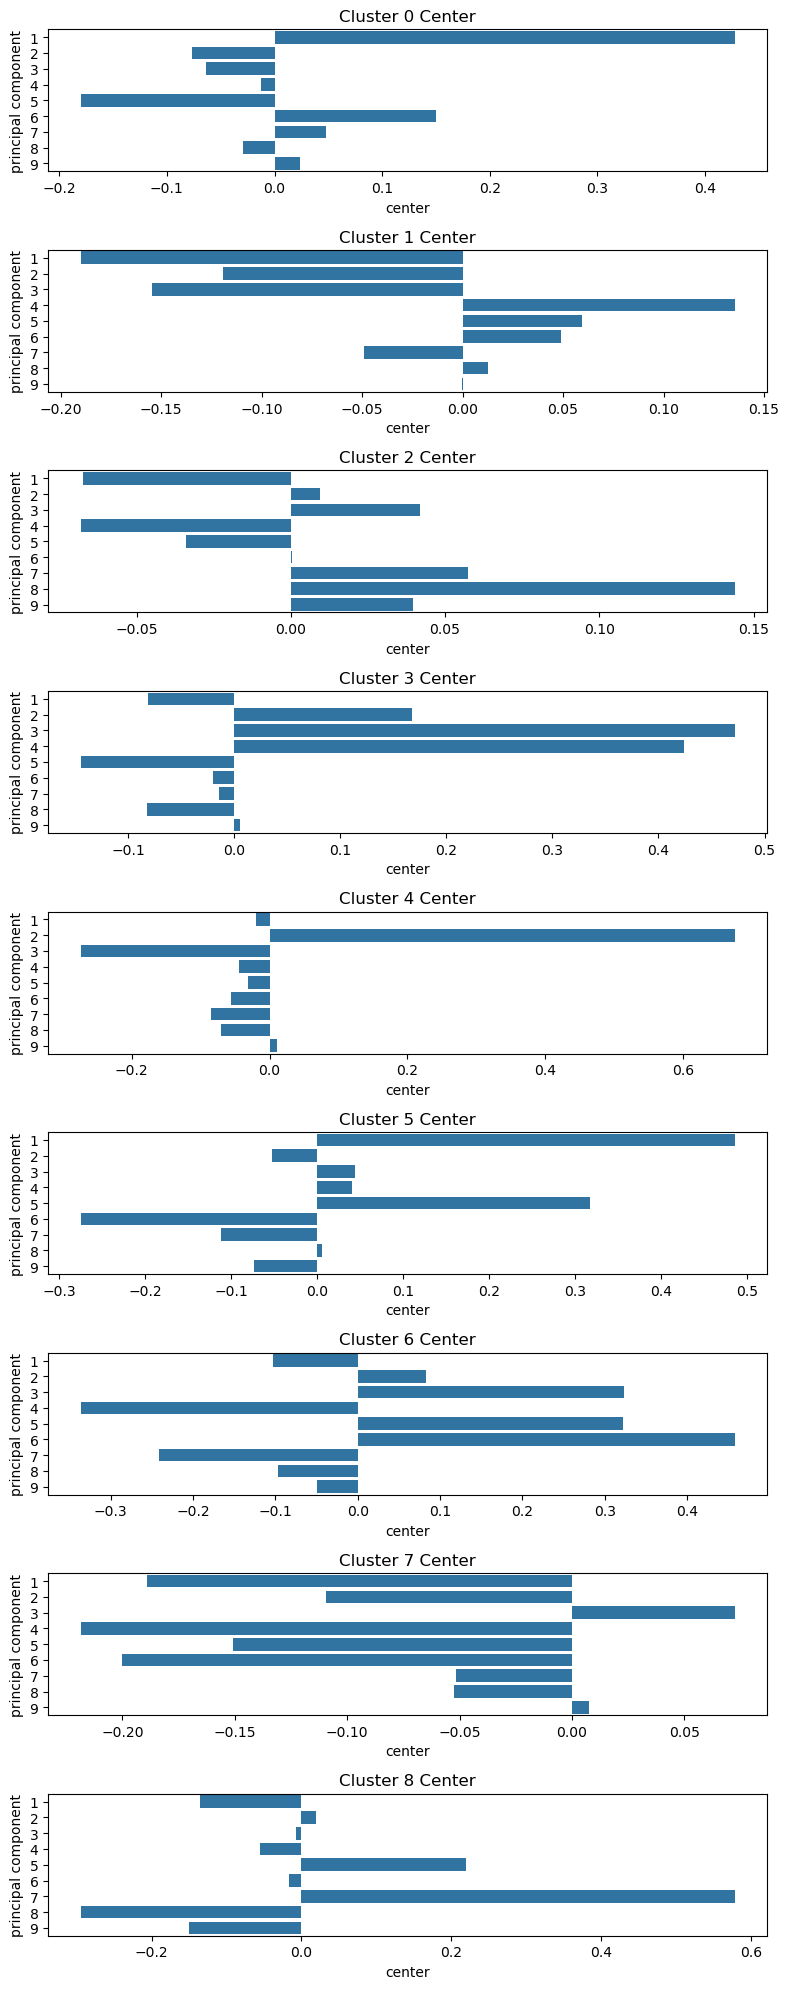

In [271]:
centers_df = pd.DataFrame(kmeans.cluster_centers_)

fig, axes = plt.subplots(nrows = 9, ncols = 1, figsize = (8,20))
axes = axes.flatten()
for i in range(len(centers_df)):
    tmp = centers_df.iloc[i].rename_axis('principal component').reset_index().rename(columns = {i:'center'})
    tmp['principal component'] = list(range(1,10))
    tmp['principal component'] = tmp['principal component'].astype('object')
    sns.barplot(data = tmp, x = 'center', y = 'principal component', ax = axes[i], orient = 'h')
    axes[i].set_title(f'Cluster {i} Center')
plt.tight_layout()
plt.show()

The cluster centers for each cluster are displayed above in an effort to make the clusters more interpretable. Cluster 1 is very high on PC1, which leads me to believe authors in this cluster mostly wrote about news in China. Cluster 2 is very high on PC8, so these authors probably talk about news related to the eport of cocoa, ivory, and coffee. Cluster 3 is very high on PC3 and PC4, indicating these authors write about the Bre-X scandal and gold. Cluster 4 is high on PC2, so these authors likely write about news in the Czech Republic and Eastern Europe. Cluster 5 is high on PC1 and PC5, indicating these authors wrote automobile manufacturers in China. Cluster 6 is high on PC6, indicating these authors wrote about automobile manufacturers but less related to China. Cluster 7 is high on PC3 and low on everything else, indicating these authors wrote almost exclusiely about news related to Bre-X. Cluster 8 is high on PC7, indicating these authors wrote about French markets. 

It's important to note that this is probably an oversimplification of everything that these authors wrote about, but this is a sufficient to get a basic understanding of how these authors are related to each other before recommending authors to readers.

### Conclusion

To conclude this analysis, it was possible to cluster authors based on their language usage, and these clusterings could be used to recommend new authors to readers based on their favorite authors. The authors were clustered on the basis of their language usage, so authors in one cluster generally write about more similar topics than authors in another cluster. However, since all of these authors write articles about financial and business news for Reuters, there is some similarity between all of them. The interpretability of these results could be improved by using more advanced NLP techniques such as topic extraction. It was hard to interpret how authors were similar. Knowing how authors are similar and being able to articulate that to readers may further incentivize readers to view another author's articles.